# Train Model by country

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [3]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [4]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)

# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index(drop = True)

# create average varaibles for the between model
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')

# load the feature data
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [5]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id','n_households', 'country', 'lat', 'lon',        
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

In [6]:
# define the x variables and the target variable for the between and within models

# define the between variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars
between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation + median_rgb_vars 
between_target_var = 'avg_log_mean_pc_cons_usd_2017'

# define the within varaibles
dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation + dyn_rgb_vars
within_target_var = 'log_mean_pc_cons_usd_2017'

In [7]:
# define the between and the within df

between_df = df[['cluster_id', 'country', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)
within_df = df[['unique_id', 'cluster_id', 'country',within_target_var] + within_x_vars]

# Run the CV

In [8]:
# train a model on each country and evaluate on the remaining countries.
# for the country itself, use spatial cross validation to evaluate the model

In [9]:
countries = ['eth', 'mwi', 'nga', 'tza', 'uga']
cross_cntry_res = {}

between_df_norm = standardise_df(between_df, exclude_cols = [between_target_var])
demeaned_df_norm = standardise_df(demean_df(within_df), exclude_cols = [within_target_var])
demeaned_df_norm['country'] = within_df['country']

for cntry in tqdm(countries):
    
    # subset the training data
    train_between_df_norm = between_df_norm[between_df_norm.country == cntry].reset_index(drop = True)
    train_demeaned_df_norm = demeaned_df_norm[demeaned_df_norm.country == cntry].reset_index(drop = True)
    
    # get the X and y vectors
    X_train_between = train_between_df_norm.loc[:, between_x_vars]
    y_train_between = np.array(train_between_df_norm[[between_target_var]]).ravel()
    
    X_train_within = train_demeaned_df_norm.loc[:, within_x_vars]
    y_train_within = np.array(train_demeaned_df_norm[[within_target_var]]).ravel()
    
    # train the between model
    between_rf = rf.Trainer(X_train_between, y_train_between, None, None, random_seed)
    between_rf.train(min_samples_leaf = 5)
    
    # train within model
    within_rf = rf.Trainer(X_train_within, y_train_within, None, None, random_seed)
    within_rf.train(min_samples_leaf = 15)
    
    # evaluate the between and the within models on all other countries
    val_countries = [i for i in countries if i != cntry]
    
    # define object to store results of country
    cross_cntry_res[cntry] = {
        'between_r2': [],
        'within_r2': [], 
        'overall_r2': [],
        'val_cntry': []
    }
    
    for val_cntry in val_countries:
        
        # subset the data to the validation country
        val_df = df.loc[df.country == val_cntry].reset_index(drop = True)
        
        # normalise data
        val_between_df_norm = between_df_norm[between_df_norm.country == val_cntry].reset_index(drop = True)
        val_demeaned_df_norm = demeaned_df_norm[demeaned_df_norm.country == val_cntry].reset_index(drop = True)
    
        # get the X and y vectors
        X_val_between = val_between_df_norm.loc[:, between_x_vars]
        y_val_between = np.array(val_between_df_norm[[between_target_var]]).ravel()

        X_val_within = val_demeaned_df_norm.loc[:, within_x_vars]
        y_val_within = np.array(val_demeaned_df_norm[[within_target_var]]).ravel()
        
        # validate both models on the validation country
        between_preds, between_r2, between_mse = between_rf.validate(X_val_between, y_val_between)
        between_preds_df = pd.DataFrame({
            'cluster_id': val_between_df_norm.cluster_id,
            'between_y_hat': between_preds
        })
        
        # validate the within model
        within_preds, within_r2, within_mse = within_rf.validate(X_val_within, y_val_within)
        within_preds_df = pd.DataFrame({
            'unique_id': val_demeaned_df_norm.unique_id,
            'cluster_id': val_demeaned_df_norm.cluster_id,
            'within_y_hat': within_preds
        })
        
        # combine both predictions
        preds_df = pd.merge(within_preds_df, between_preds_df, on = 'cluster_id', how = 'left')
        preds_df['y_hat'] = preds_df['between_y_hat'] + preds_df['within_y_hat']
        preds_df['y'] = val_df['log_mean_pc_cons_usd_2017']
        
        # evaluate the predictions
        overall_r2 = r2_score(preds_df['y'], preds_df['y_hat'])
        
        # results
        cross_cntry_res[cntry]['between_r2'].append(between_r2)
        cross_cntry_res[cntry]['within_r2'].append(within_r2)
        cross_cntry_res[cntry]['overall_r2'].append(overall_r2)
        cross_cntry_res[cntry]['val_cntry'].append(val_cntry)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# save results
pth = 'results/robustness/cross_cntry_res.pkl'
with open(pth, 'wb') as f:
    pickle.dump(cross_cntry_res, f)

# Train on country and evaluate on country

In [13]:
same_cntry_res = {
    'country': [],
    'between_r2': [],
    'within_r2': [],
    'overall_r2': []
}
it = 0
for cntry in tqdm(countries):
    print("="*100)
    print(f"Training and Evaluating on country {cntry}")
    print("="*100)
    print("\n")
    
    # subset the df to country
    df_sub = df.loc[df.country == cntry].reset_index(drop = True)
    between_df_sub = between_df[between_df.country == cntry].reset_index(drop = True)
    within_df_sub = within_df[within_df.country == cntry].reset_index(drop = True)
    
    # standardise the datasets
    between_df_norm = standardise_df(between_df_sub, exclude_cols = [between_target_var])
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])

    aux_r2_b = []
    aux_r2_w = []
    aux_r2_o = []
    
    for j in range(10):
        print("."*100)
        print(f"Iteration {j}")
        print("."*100)
        
        seeed = random_seed + j + it
        
        # get training and validation ids using spatial CV scheme
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)
        
        # run the bewtween training
        print('\n\tBetween model')
        between_cv_trainer = rf.CrossValidator(between_df_norm, 
                                               fold_ids,
                                               between_target_var, 
                                               between_x_vars, 
                                               id_var = 'cluster_id',
                                               random_seed = seeed)
        between_cv_trainer.run_cv_training(min_samples_leaf = 5)
        between_res = between_cv_trainer.compute_overall_performance()

        # run the within training
        print('\n\tWithin Model')
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 15)
        within_res = within_cv_trainer.compute_overall_performance()

        # run the combined model
        combined_model = CombinedModel(df_sub, between_cv_trainer, within_cv_trainer)
        combined_model.evaluate()
        combined_res = combined_model.compute_overall_performance()
        print(f"\t{combined_res['r2']}")

        # store results
        aux_r2_b.append(combined_res['r2']['between'])
        aux_r2_w.append(combined_res['r2']['within'])
        aux_r2_o.append(combined_res['r2']['overall'])
        
    it += 1
    
    # take the average over all results
    same_cntry_res['country'].append(cntry)
    same_cntry_res['between_r2'].append(np.mean(aux_r2_b))
    same_cntry_res['within_r2'].append(np.mean(aux_r2_w))
    same_cntry_res['overall_r2'].append(np.mean(aux_r2_o))

  0%|          | 0/5 [00:00<?, ?it/s]

Training and Evaluating on country eth


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 53 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 69 seconds
	{'overall': 0.3077962798418053, 'between': 0.40919473391720873, 'within': 0.09107822987644609}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 51 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 65 seconds
	{'overall': 0.26025135006211386, 'between': 0.33890983636051386, 'within': 0.09587256726313634}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 55 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 81 seconds
	{'overall': 0.2751505546786301, 'between': 0.3587579302825841, 'within': 0.07523726063244132}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds
	{'overall': 0.29878348730354104, 'between': 0.386402556772843, 'within': 0.0674728815974314}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 71 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 110 seconds
	{'overall': 0.2802720320690453, 'between': 0.3651005536022533, 'within': 0.08373616248943391}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds
	{'overall': 0.2893357971283626, 'between': 0.38444984108417424, 'within': 0.09096773686728847}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.3025417149498995, 'between': 0.38364082980129566, 'within': 0.09680787043188713}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 76 seconds
	{'overall': 0.2727516905922212, 'between': 0.35460787414930295, 'within': 0.09178502367411065}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 84 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 78 seconds
	{'overall': 0.2823884568371272, 'between': 0.3734340176403732, 'within': 0.08146880627947975}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 57 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 72 seconds
	{'overall': 0.2886471230780821, 'between': 0.3962019201267009, 'within': 0.08435879619484452}
Training and Evaluating on country mwi


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 46 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 43 seconds
	{'overall': 0.3002522058589536, 'between': 0.33673762734776946, 'within': -0.04457245395280842}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 54 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 69 seconds
	{'overall': 0.3200224946322965, 'between': 0.3490198594818062, 'within': -0.006231418381200449}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 51 seconds
	{'overall': 0.13732446609619814, 'between': 0.1500919136909123, 'within': -0.002168495482773203}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.31
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.08

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 64 seconds
	{'overall': -0.0677236268313822, 'between': -0.08354513346344056, 'within': -0.016013392374916724}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 57 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 60 seconds
	{'overall': 0.12272741427309007, 'between': 0.13185772514314517, 'within': 0.011934861059885615}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 53 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 59 seconds
	{'overall': 0.18356493839576718, 'between': 0.19294249282809126, 'within': -0.03731689645497782}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 59 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 64 seconds
	{'overall': 0.1550314695249528, 'between': 0.17846616235771023, 'within': -0.052328790400751536}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 59 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds
	{'overall': 0.21097210043248077, 'between': 0.24024083583389766, 'within': -0.010565422265206403}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 53 seconds
	{'overall': 0.19055028887112863, 'between': 0.20714914195486275, 'within': -0.04114906235305971}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 53 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 53 seconds
	{'overall': 0.3312368987765969, 'between': 0.36284039723866174, 'within': 0.008761653118539558}
Training and Evaluating on country nga


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 81 seconds
	{'overall': 0.39113598966276386, 'between': 0.48032577799663534, 'within': 0.006810037147265646}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 85 seconds
	{'overall': 0.4003473864421567, 'between': 0.49451215040257607, 'within': 0.008276243283425045}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 80 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'overall': 0.40507285333788046, 'between': 0.5025591903391983, 'within': 0.008729324858488475}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 87 seconds
	{'overall': 0.3959511136406031, 'between': 0.4926725243311383, 'within': -0.010379598724704397}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 56 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 82 seconds
	{'overall': 0.3900072618804884, 'between': 0.48633205090216497, 'within': -0.017705381637709496}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 60 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 85 seconds
	{'overall': 0.40845114580250175, 'between': 0.5048310015162804, 'within': -0.0026726174981676065}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 89 seconds
	{'overall': 0.4105076931959868, 'between': 0.5093083833243108, 'within': -0.009589260655874132}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 66 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 94 seconds
	{'overall': 0.3806116720083243, 'between': 0.47409668946152556, 'within': 0.00369399034641551}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 76 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 103 seconds
	{'overall': 0.400982279376286, 'between': 0.4981433863583596, 'within': -0.0014521403155660418}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 65 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 64 seconds
	{'overall': 0.398045475991667, 'between': 0.49501763782299896, 'within': 0.0004567982558093098}
Training and Evaluating on country tza


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 65 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 119 seconds
	{'overall': 0.2924251997005497, 'between': 0.339124189371112, 'within': 0.008898276107180414}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.3030315594582934, 'between': 0.34660594466322997, 'within': 0.0012935651415633131}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.2904095224381552, 'between': 0.3272027967697537, 'within': 0.008986676484275601}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'overall': 0.2741719811411238, 'between': 0.31915641845951026, 'within': 0.02193464288587834}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 90 seconds
	{'overall': 0.27043007836248706, 'between': 0.29966610895888607, 'within': 0.007635087676971164}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.30
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 90 seconds
	{'overall': 0.32000217623339755, 'between': 0.37436731732482487, 'within': -0.0036564236248883162}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 60 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.27520416163040734, 'between': 0.3040681858190664, 'within': 0.023119268809603445}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.2605163590266719, 'between': 0.2991691117296289, 'within': 0.008387776150202008}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.239505534754286, 'between': 0.2683835034020393, 'within': 0.01862247295605244}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 60 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'overall': 0.2595632334553118, 'between': 0.29277776567840574, 'within': 0.013954786980865474}
Training and Evaluating on country uga


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.32
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.08

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 43 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.28527376820605, 'between': 0.3229212187503063, 'within': 0.04829495480094472}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 80 seconds
	{'overall': 0.244761944319221, 'between': 0.27830528044171654, 'within': 0.05466729908836652}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.27784929518206936, 'between': 0.3109154260395918, 'within': 0.050462926423416654}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.36350456490329885, 'between': 0.4429057290708957, 'within': 0.057540603122051136}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 86 seconds
	{'overall': 0.31160293819126944, 'between': 0.3865167330253438, 'within': 0.05871917276776113}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 82 seconds
	{'overall': 0.2928880496613229, 'between': 0.35869472408872993, 'within': 0.04854651003960664}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 80 seconds
	{'overall': 0.3145862922481168, 'between': 0.3702199845274607, 'within': 0.051962752302337004}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 80 seconds
	{'overall': 0.29284394577649414, 'between': 0.32505777588783474, 'within': 0.05109997846194299}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.2951623370670927, 'between': 0.33545632111360973, 'within': 0.05096173493981095}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds
	{'overall': 0.1763781938773185, 'between': 0.1957841283104348, 'within': 0.05518397683346445}


In [14]:
pth = 'results/robustness/same_cntry_res.pkl'
with open(pth, 'wb') as f:
    pickle.dump(same_cntry_res, f)

# Make the plot

In [15]:
# load the data
pth = 'results/robustness/same_cntry_res.pkl'
with open(pth, 'rb') as f:
    same_cntry_res = pickle.load(f)
    
pth = 'results/robustness/cross_cntry_res.pkl'
with open(pth, 'rb') as f:
    cross_cntry_res = pickle.load(f)

In [16]:
same_cntry_df = pd.DataFrame(same_cntry_res)

In [17]:
# combine cross cntry and same cntry results to one matrix
res_dict = {}
for cntry, res in cross_cntry_res.items():
    res_df = pd.DataFrame(res)
    same_df = same_cntry_df[same_cntry_df.country == cntry]
    same_df = same_df.rename(columns = {'country': 'val_cntry'})
    res_df = pd.concat([res_df, same_df], ignore_index = True)
    res_dict[cntry] = res_df.sort_values(by = 'val_cntry').reset_index(drop = True)

In [18]:
res_dict['eth']
between_df = pd.DataFrame({
    'eth': [], 
    'mwi': [],
    'nga': [],
    'tza': [],
    'uga': []
})

within_df = copy.deepcopy(between_df)
overall_df = copy.deepcopy(between_df)

final_res = {
    'between_r2': between_df,
    'within_r2': within_df,
    'overall_r2': overall_df
}

for cntry, res_df in res_dict.items():
    for r2, final_df in final_res.items():
        aux_df = res_dict[cntry][[r2, 'val_cntry']].T
        aux_df.columns = aux_df[aux_df.index == 'val_cntry'].values[0]
        aux_df = aux_df[aux_df.index != 'val_cntry']
        aux_df = aux_df.rename(index = {r2: cntry})
        final_res[r2] = pd.concat([final_df, aux_df], ignore_index = False)
        
for r2, df in final_res.items():
    final_res[r2].columns = [i.upper() for i in final_res[r2].columns.values]
    final_res[r2].index = [i.upper() for i in final_res[r2].index.values]
    final_res[r2] = final_res[r2].sort_index()
    
    

In [19]:
import seaborn as sns

In [20]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
sns.set(font_scale=3)

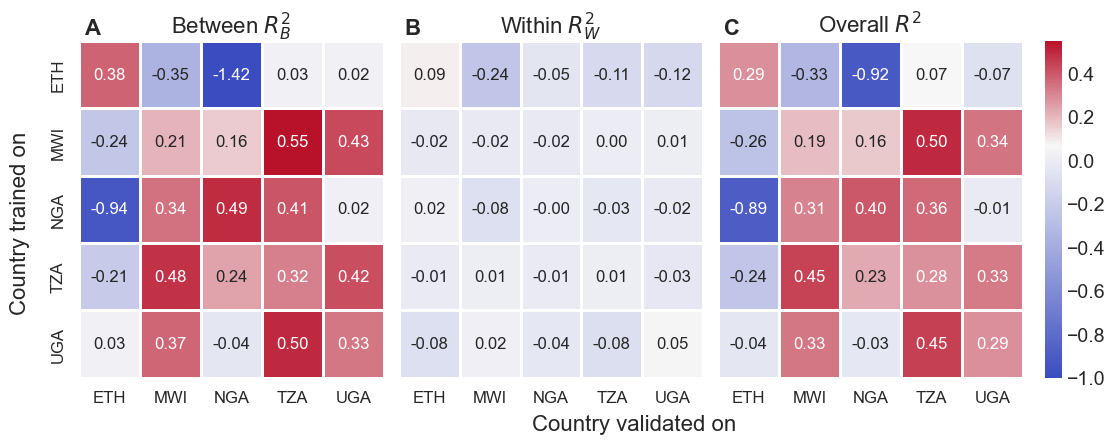

In [21]:
letters =  ['A', 'B', 'C']
sns.set_theme(style="white")

# Create a figure and axis for the plot
fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey = True)

data_between = final_res['between_r2'].astype(float)
data_within = final_res['within_r2'].astype(float)
data_overall = final_res['overall_r2'].astype(float)

colors = ['#3B4CC0', '#F7F7F7', '#B8122A']  # Blue, Gray, Red

# Define the positions for the color transitions
positions = [0, 0.69, 1]  # Corresponding to blue, gray, and red

# Create a colormap with color transitions around 0
cmap = LinearSegmentedColormap.from_list("BlueGrayRed", list(zip(positions, colors)), N=256)

# Define the color map with segmented colors

common_vmin = max(min(data_between.min().min(), data_within.min().min(), data_overall.min().min()),-1)
common_vmax = max(data_between.max().max(), data_within.max().max(), data_overall.max().min())

#cmap = LinearSegmentedColormap.from_list("BlueGrayRed", colors, N=256)


#sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, ax=ax, linewidths=1)

# Create heatmaps for each data frame and place them in the subplots
heatmap_between = sns.heatmap(data_between, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[0], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_within = sns.heatmap(data_within, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[1], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_overall = sns.heatmap(data_overall, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[2], linewidths=1, vmin=common_vmin, vmax=common_vmax)

plt.tight_layout()

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
# cbar = fig.colorbar(heatmap_overall, cax=cbar_ax)
# Create a common color bar based on vmin and vmax
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=common_vmin, vmax=common_vmax))
sm.set_array([])  # Dummy empty array for the ScalarMappable

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02)
cbar.ax.tick_params(size=0, labelsize = 14)
cbar.outline.set_visible(False)

# Set titles for each subplot
heatmap_between.set_title('Between $R^2_B$', size = 16)
heatmap_within.set_title('Within $R^2_W$', size = 16)
heatmap_overall.set_title('Overall $R^2$', size = 16)

for ax in axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# add letter to every plot
text_y = 1.02
text_x = 0.02
axes[0].text(text_x, text_y, 'A', transform=axes[0].transAxes, weight='bold', size = 16)
axes[1].text(text_x, text_y, 'B', transform=axes[1].transAxes, weight='bold', size = 16)
axes[2].text(text_x, text_y, 'C', transform=axes[2].transAxes, weight='bold', size = 16)

# Show the plot
fig.text(0.5, -.02, "Country validated on", ha="center", size = 16)
fig.text(-.02, 0.5, "Country trained on", va="center", rotation="vertical", size = 16)
plt.savefig('../figures/results/cross_cntry_validation.png', dpi = 300, bbox_inches='tight')
plt.show()